In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants as const

# Проект "Движение частицы в магнитном поле"

Частица заряда $q$ и массы $m$

Уравнения движения:
$$ \dot{\vec{v}} = \frac{q}{mc} \vec{v}\times\vec{B}~~~~~~~~(1)$$
$$\dot{\vec{r}} = \vec{v}~~~~~~~~(2)$$
где
$$\vec{v} = v_x\vec{i} + v_y\vec{j} + v_z \vec{k}$$
$$\vec{r} = x \vec{i} + y\vec{j} + z \vec{k}$$


## Подготовка к численному решению

Введём обозначения:
$$\vec{b}(\vec{r}) = \frac{\vec{B}(\vec{r})}{B_0},~~~\omega_0 = \frac{q B_0}{mc}$$
$$\vec{f}(\vec{v}, \vec{r}) = \omega_0 \begin{bmatrix}
v_y b_z(\vec{r}) - v_z b_y(\vec{r})\\
v_z b_x(\vec{r}) - v_x b_z(\vec{r})\\
v_x b_y(\vec{r}) - v_y b_x(\vec{r})
\end{bmatrix}$$
Тогда (1) ур-е запишется в виде:
$$ \dot{\vec{v}} = \vec{f}(\vec{v}, \vec{r}) $$
Применим к нему явный метод Рунге-Кутты 4 порядка
$$ \vec{k}_1 = \vec{f}(\vec{v}_n, \vec{r}_n) $$
$$ \vec{k}_2 = \vec{f}(\vec{v}_n + \tau \frac{\vec{k}_1}{2}, \vec{r}_n) $$
$$ \vec{k}_3 = \vec{f}(\vec{v}_n + \tau \frac{\vec{k}_2}{2}, \vec{r}_n) $$
$$ \vec{k}_4 = \vec{f}(\vec{v}_n + \tau \vec{k}_3, \vec{r}_n) $$
$$ \vec{v}_{n+1} = \vec{v}_n + \tau \frac{\vec{k}_1+2\vec{k}_2+2\vec{k}_3+\vec{k}_4}{6} $$

Для решения уравнения (2) применим к нему метод Рунге-Кутты 1 порядка (метод Эйлера)
$$ \vec{r}_{n+1} = \vec{r}_n + \tau \vec{v}_{n+1} $$

In [2]:
# Solving the motion equation using the 4th-order and 1st-order Rounge-Kutta methods
def SolveMotionEquations(omega_0, v_0, r_0, Bx_fun, By_fun, Bz_fun, tb, te, N_steps):
    v_fun = lambda v_, B_ : omega_0 * np.array([(v_[1] * B_[2] - v_[2] * B_[1]), (v_[2] * B_[0] - v_[0] * B_[2]), (v_[0] * B_[1] - v_[1] * B_[0])])
    t, tau = np.linspace(tb, te, N_steps, retstep=True)
    v = np.zeros((N_steps+1, 3))
    v[0, :] = v_0
    r = np.zeros((N_steps+1, 3))
    r[0, :] = r_0
    for i in range(0, N_steps):
        Bi = np.array([Bx_fun(r[i, 0], r[i, 2]), By_fun(r[i, 1], r[i, 2]), Bz_fun(r[i, 2])])
        k1 = v_fun(v[i, :], Bi)
        k2 = v_fun(v[i, :] + tau * k1 / 2, Bi)
        k3 = v_fun(v[i, :] + tau * k2 / 2, Bi)
        k4 = v_fun(v[i, :] + tau * k3, Bi)
        v[i+1, :] = v[i, :] + tau * (k1 + 2 * k2 + 2 * k3 + k4)/6
        r[i+1, :] = r[i, :] + tau * v[i+1, :]
    return (r, v, t)

In [3]:
# Function for plotting solutions
def PlotSolutions(r, v, Bx_fun, By_fun, Bz_fun, xlims, ylims, zlims):
    N = 10
    # %config InlineBackend.figure_format = 'svg'
    N_steps = np.shape(r)[0]
    choice = np.array(range(0, N_steps)) % 2 == 0
    x = np.linspace(xlims[0], xlims[1], N)
    y = np.linspace(ylims[0], ylims[1], N)
    z = np.linspace(zlims[0], zlims[1], N)

    fig = plt.figure(1, figsize=(16, 13))
    scl = 25

    # Plane XY
    plt.subplot(2, 2, 1)
    layer_z = int(N/2)
    X, Y = np.meshgrid(x, y)
    B_x = Bx_fun(X, z[layer_z])
    B_y = By_fun(Y, z[layer_z])
    color = np.sqrt(B_x**2 + B_y**2)
    plt.streamplot(x, y, B_x, B_y, color=color, linewidth=2*color/color.max(), cmap=plt.cm.plasma, density=2)
    plt.colorbar()
    plt.quiver(r[choice, 0], r[choice,1], v[choice, 0], v[choice,1], scale=scl)
    plt.title("Магнитное поле в плоскости XY при z = 0")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(ylims)
    plt.xlim(xlims)

    # Plane XZ
    plt.subplot(2, 2, 2)
    layer_y = int(N/2)
    X, Z = np.meshgrid(x, z)
    B_x = Bx_fun(X, Z)
    B_z = Bz_fun(Z)
    color = np.sqrt(B_x**2 + B_z**2)
    plt.streamplot(x, z, B_x, B_z, color=color, cmap=plt.cm.plasma, density=2, linewidth=2*color/color.max())
    plt.colorbar()
    plt.quiver(r[choice, 0], r[choice,2], v[choice, 0], v[choice,2], scale=scl)
    plt.title("Магнитное поле в плоскости XZ при y = 0")
    plt.xlabel("x")
    plt.ylabel("z")
    plt.ylim(zlims)
    plt.xlim(xlims)

    # Plane YZ
    plt.subplot(2, 2, 3)
    layer_x = int(N/2)
    Y, Z = np.meshgrid(y, z)
    B_y = By_fun(Y, Z)
    B_z = Bz_fun(Z)
    color = np.sqrt(B_y**2 + B_z**2)
    plt.streamplot(y, z, B_y, B_z, color=color, linewidth=2*color/color.max(), cmap=plt.cm.plasma, density=2)
    plt.colorbar()
    plt.quiver(r[choice, 1], r[choice,2], v[choice, 1], v[choice,2], scale=scl)
    plt.title("Магнитное поле в плоскости YZ при x = 0")
    plt.xlabel("y")
    plt.ylabel("z")
    plt.ylim(zlims)
    plt.xlim(ylims)

    plt.show()

## Задача 1. Движение в поле магнитного зеркала

Поле магнитного зеркала
$$ B_x = - \frac{x}{2} \cdot \frac{B_1 - B_0}{\pi l} \cdot \frac{1}{1 + \frac{(z-l)^2}{l^2}} $$
$$ B_y = - \frac{y}{2} \cdot \frac{B_1 - B_0}{\pi l} \cdot \frac{1}{1 + \frac{(z-l)^2}{l^2}} $$
$$ B_z = B_0 + \frac{B_1 - B_0}{\pi}\cdot \left(\frac{\pi}{2} + \arctan\frac{z-L}{l}\right) $$

Начальные условия
$$ \vec{r}(0) = \begin{bmatrix}
\frac{V_1}{\omega_0}\\
0\\
-L
\end{bmatrix},~~~
\vec{v}(0) = \begin{bmatrix}
0\\
-V_1\\
V_1 \cot \alpha
\end{bmatrix},  $$
где
$$ \omega_0 = 1,~~~B_1 = 2 B_0,~~~V_1 = 1,~~~l=10,~~~L=40,~~~\alpha\in\left[\frac{\pi}{4};\frac{\pi}{2}\right] $$

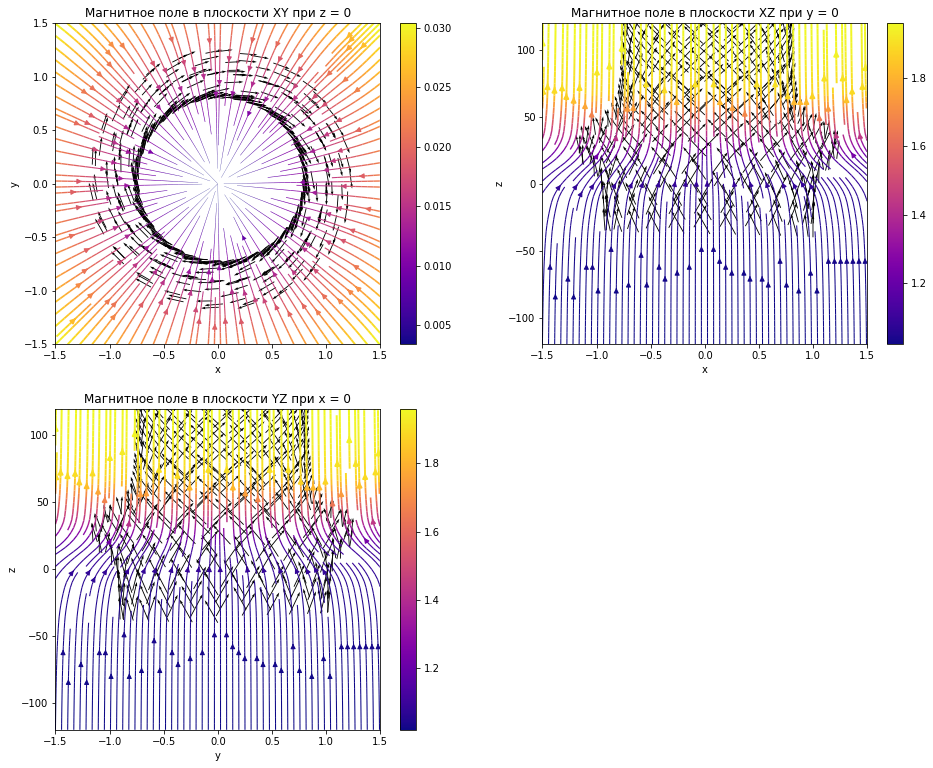

In [4]:
# Initial conditions
omega_0 = 1
B = 2
V_1 = 1
l = 10
L = 40
alpha = const.pi / 6
r_0 = np.array([V_1/omega_0, 0, -L])
v_0 = np.array([0, -V_1, V_1 / np.tan(alpha)])

# Magnetic field functions
Bx_fun = lambda X, Z : -X/2 * (B - 1) / const.pi / l / (1 + (Z/l - 1)**2)
By_fun = lambda Y, Z : -Y/2 * (B - 1) / const.pi / l / (1 + (Z/l - 1)**2)
Bz_fun = lambda Z : 1 + (B - 1) / const.pi * (const.pi/2 + np.arctan((Z - L)/l))

# Solving and plotting
r, v, t = SolveMotionEquations(omega_0, v_0, r_0, Bx_fun, By_fun, Bz_fun, 0, 120, 1000)
PlotSolutions(r, v, Bx_fun, By_fun, Bz_fun, (-1.5, 1.5), (-1.5, 1.5), (-3 * L, 3 * L))

## Задача 2. Движение в поле магнитной ловушки

Поле магнитной ловушки
$$ B_x = - \frac{x}{2} \cdot \frac{B_1 - B_0}{2 l} \cdot \pi \cdot \sin \frac{\pi z}{l} $$
$$ B_y = - \frac{y}{2} \cdot \frac{B_1 - B_0}{2 l} \cdot \pi \cdot \sin \frac{\pi z}{l} $$
$$ B_z = B_0 + \frac{B_1 - B_0}{2}\cdot \left(1 - \cos\frac{\pi z}{l}\right) $$

Начальные условия
$$ \vec{r}(0) = \begin{bmatrix}
\frac{V_1}{\omega_0}\\
0\\
0
\end{bmatrix},~~~
\vec{v}(0) = \begin{bmatrix}
0\\
-V_1\\
-V_1 \cot \alpha
\end{bmatrix},  $$
где
$$ \omega_0 = 1,~~~\frac{B_1}{B_0} = 2,~~~V_1 = 1,~~~l=20,~~~\alpha\in\left[\frac{\pi}{4};\frac{\pi}{2}\right] $$

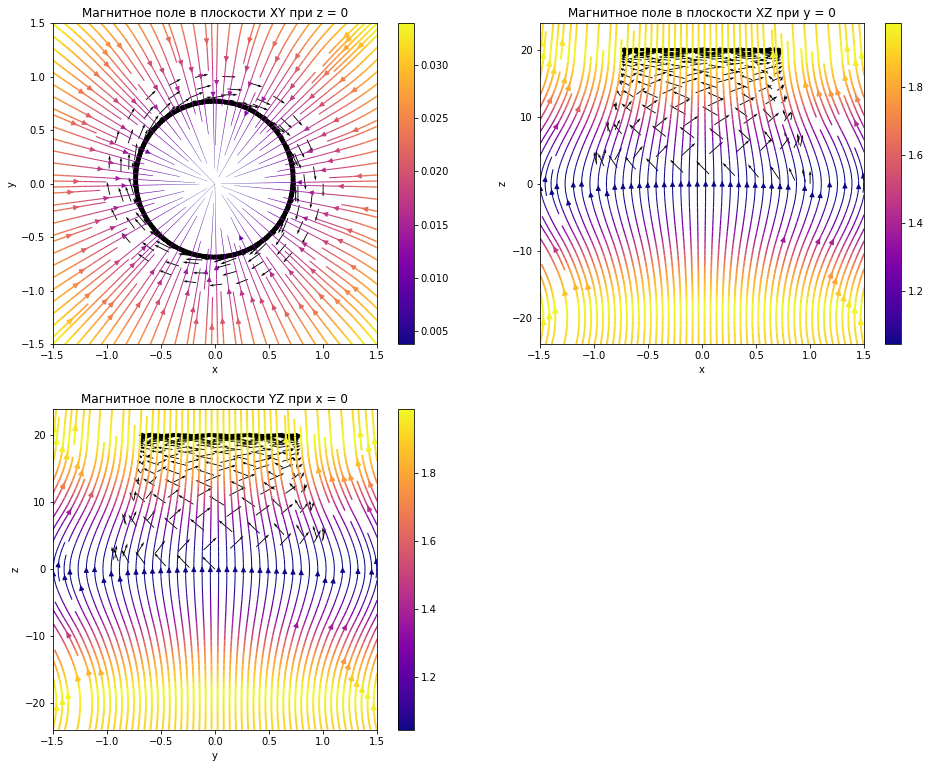

In [5]:
# Initial conditions
omega_0 = 1
B = 2
V_1 = 1
l = 20
alpha = 3 * const.pi / 4
r_0 = np.array([V_1/omega_0, 0, 0])
v_0 = np.array([0, -V_1, -V_1 / np.tan(alpha)])

# Magnetic field mesh
Bx_fun = lambda X, Z : -X/2 * (B - 1) * const.pi / 2 / l * np.sin(const.pi * Z / l)
By_fun = lambda Y, Z : -Y/2 * (B - 1) * const.pi / 2 / l * np.sin(const.pi * Z / l)
Bz_fun = lambda Z : 1 + (B - 1) / 2 * (1 - np.cos(const.pi * Z/l))

# Solving and plotting
r, v, t = SolveMotionEquations(omega_0, v_0, r_0, Bx_fun, By_fun, Bz_fun, 0, 120, 1000)
PlotSolutions(r, v, Bx_fun, By_fun, Bz_fun, (-1.5, 1.5), (-1.5, 1.5), (-1.2 * l, 1.2 * l))